In [178]:
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import utils
import imp
imp.reload(utils)

wd = 'E:/new_data/kaggle/planet/'
train_set = pd.read_csv(wd + 'train_v2.csv')
train_set['tags'] = train_set['tags'].apply(lambda x: x.split(' '))
test_set = pd.read_csv(wd+'sample_submission_v2.csv')
train_tags = ['clear', 'partly_cloudy', 'haze', 'cloudy', 'primary', 'agriculture', 'road', 'water',
             'cultivation', 'habitation', 'bare_ground', 'selective_logging', 'artisinal_mine', 
              'blooming', 'slash_burn', 'conventional_mine', 'blow_down']
label_map = {l: i for i, l in enumerate(train_tags)}
inv_label_map = {i: l for l, i in label_map.items()}
file_all = train_set['image_name'].values
y_train = utils.get_y(train_set['tags'].values, label_map)
test_file_all = test_set['image_name'].values

tr_dir = 'E:/new_data/kaggle/planet/train-jpg/'
ts_dir = 'E:/new_data/kaggle/planet/test-jpg/'

In [103]:
X_train= utils.get_x(ts_dir)

100%|█████████████████████████████████████| 40479/40479 [11:23<00:00, 59.25it/s]


In [137]:
X_test = utils.get_x(ts_dir)

100%|█████████████████████████████████████| 61191/61191 [13:58<00:00, 73.00it/s]


In [225]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold # 分层交叉验证
from sklearn.metrics import fbeta_score

p_tr = np.zeros((X_train.shape[0], 17))
y_ts = np.zeros((X_test.shape[0], 17))
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'device': 'gpu',
    'verbosity': -1
}

num_classes = 17
n_splits = 5
for i_c in range(num_classes):
    skf = StratifiedKFold(n_splits=n_splits)
    w = utils.get_weight(y_train[:, i_c])
    k_now = 0
    for i_tr, i_vl in skf.split(X_train, y_train[:, i_c]):
        print(i_c, k_now)
        lgb_train = lgb.Dataset(X_train[i_tr], y_train[i_tr, i_c], weight=w[i_tr], free_raw_data=False)
        lgb_eval = lgb.Dataset(X_train[i_vl], y_train[i_vl, i_c], reference=lgb_train, weight=w[i_vl], free_raw_data=False)
        bst = lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=30)
        p_tr[i_vl, i_c]= bst.predict(X_train[i_vl], num_iteration=bst.best_iteration)
        y_ts[:, i_c] = bst.predict(X_test, num_iteration=bst.best_iteration) / float(n_splits)
        k_now += 1

0 0
[1]	valid_0's binary_logloss: 0.663304
Train until valid scores didn't improve in 30 rounds.
[2]	valid_0's binary_logloss: 0.635192
[3]	valid_0's binary_logloss: 0.610175
[4]	valid_0's binary_logloss: 0.58765
[5]	valid_0's binary_logloss: 0.565979
[6]	valid_0's binary_logloss: 0.546445
[7]	valid_0's binary_logloss: 0.527459
[8]	valid_0's binary_logloss: 0.510548
[9]	valid_0's binary_logloss: 0.494027
[10]	valid_0's binary_logloss: 0.478597
[11]	valid_0's binary_logloss: 0.464783
[12]	valid_0's binary_logloss: 0.451793
[13]	valid_0's binary_logloss: 0.439671
[14]	valid_0's binary_logloss: 0.427694
[15]	valid_0's binary_logloss: 0.417291
[16]	valid_0's binary_logloss: 0.406896
[17]	valid_0's binary_logloss: 0.397039
[18]	valid_0's binary_logloss: 0.387637
[19]	valid_0's binary_logloss: 0.378746
[20]	valid_0's binary_logloss: 0.370485
[21]	valid_0's binary_logloss: 0.36256
[22]	valid_0's binary_logloss: 0.355178
[23]	valid_0's binary_logloss: 0.348404
[24]	valid_0's binary_logloss: 0.

In [228]:
y_ts

array([[  1.98040707e-01,   2.66748085e-04,   1.01004422e-02, ...,
          6.00138501e-02,   6.01331593e-02,   6.98074969e-02],
       [  1.99411290e-01,   1.34983046e-03,   2.04262756e-03, ...,
          6.00261425e-02,   6.01331593e-02,   1.18991084e-01],
       [  1.43825691e-03,   1.98042085e-01,   3.22505001e-03, ...,
          9.85520179e-02,   5.94959866e-02,   8.61792880e-02],
       ..., 
       [  1.99702342e-01,   6.03010822e-04,   2.04262756e-03, ...,
          6.00261425e-02,   6.01331593e-02,   8.46595337e-02],
       [  4.58569449e-04,   1.18324566e-04,   3.98227374e-02, ...,
          6.00261425e-02,   6.01331593e-02,   6.99369702e-02],
       [  1.99054431e-01,   1.32996922e-03,   2.05899988e-02, ...,
          6.50090200e-02,   5.95411026e-02,   6.99368564e-02]])

In [229]:
th1 = utils.f2_opti_score(y_train, p_tr, thresholds = np.arange(0, 1, 0.01))
th2 = utils.f2_opti_score(y_train, p_tr, thresholds = np.arange(1, 0, -0.01))
th = (th1 + th2) / 2.0
utils.f2_score(y_train, p_tr, th, num_classes=17)

0.88217192190895743

In [230]:
np.save('./pred/modelsiftgdbt_date719_pred_train.npy', p_tr)
np.save('./pred/modelsiftgdbt_date719_pred_test.npy', y_ts)

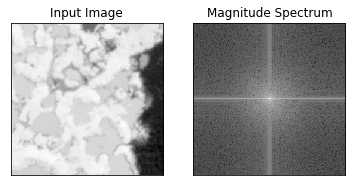

In [66]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
%matplotlib inline 
tr_dir = 'E:/new_data/kaggle/planet/train-jpg/'
img_paths = os.listdir(tr_dir)
img = Image.open(tr_dir + img_paths[20000]).convert('L')
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

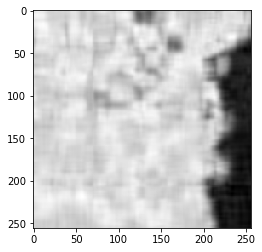

In [69]:
from scipy import linalg
u, s, v = linalg.svd(np.array(img))
plt.imshow(u[:, :10].dot(np.diag(s[:10])).dot(v[:10, :]), cmap="gray")

In [144]:
X_train.shape

(40479, 281)

In [80]:
from scipy import stats
img = Image.open(tr_dir + img_paths[20000]).convert('RGB')
img = np.array(img)
print(stats.kurtosis(img[:,:,0]), stats.kurtosis(img[:,:,1]), stats.kurtosis(img[:,:,2]))

[ 1.96213549  0.43091843  0.4857404   0.71746782  2.0699293   4.78019574
  4.60960704  2.90834441  1.53971432  1.5306683   1.48618234  1.01235334
  1.19224603  1.59968823  2.25705132  2.87626106  1.40873033  0.17248126
  0.94977174  1.81656654  2.88775278  2.97282878  2.58755426  2.40811347
  2.0765184   1.28458154  1.31217256  1.65826235  2.37327237  2.06292515
  1.4248491   1.17322211  2.42805375  1.82629269  4.12287135  6.47763249
  3.39554266  0.37659966 -0.32742932 -0.34732741  0.26657441  1.27929129
  2.46020453  1.5225384   0.87466071  4.17018782  7.42711901  9.35764498
  8.88180656  4.3697127   0.93365386  0.58498746  0.21878806  0.21686863
  0.62028479  0.81918174  2.05401859  2.33205701  2.1199739   0.85447438
  0.1071987   0.09572299  0.26401107  0.27576437 -0.08007058 -0.30178311
 -0.50011617 -0.30677839  0.1362872   0.814447    1.61981049  1.81749551
  3.17008927  5.07947761  6.05711179  5.08975006  4.19934794  4.7918326
  5.35002591  4.8327113   4.03554151  3.92254761  4.

In [83]:
print(stats.kurtosis(img.ravel()))

0.35544151275001346


In [138]:
a= np.array([1,2,3])
b = a
b[0]=100
print(a,b)


[100   2   3] [100   2   3]


In [175]:
import sys
sys.version[:3]

'3.5'

In [184]:
0.99**10

0.9043820750088044